# Sigmoid 3 Outputs

In [1]:
import pandas as pd
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.charts import Histogram, Line, Bar
#from bokeh.charts.operations import blend
import matplotlib.pyplot as plt
import numpy as np
import gzip
output_notebook()

/Users/KnightBaron/.virtualenvs/tensorflow/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

In [2]:
INPUT_FILE = "/Users/KnightBaron/Projects/dnn_flow_clustering/test_3outputs/3outputs.csv.gz"
WINDOW_SIZE = 10
OUTPUT_SIZE = 3
# Generating global variables from parameters above
LABELS = ["protocol","src_prt", "dst_prt"]
BYTE_LABELS = ["byte_{}".format(i) for i in range(WINDOW_SIZE)]
PACKET_LABELS = ["packet_{}".format(i) for i in range(WINDOW_SIZE)]
OUTPUT_LABELS = ["output_{}".format(i) for i in range(OUTPUT_SIZE)]
LABELS += BYTE_LABELS
LABELS += PACKET_LABELS
LABELS += OUTPUT_LABELS
LABELS += ["group"]

In [3]:
def create_histogram_dataframe(series_list=[], weights=[], bins="auto", hist_range=[0, 10], columns=None):
    x = None
    ys = []
    for series, weight in zip(series_list, weights):
        histogram, edges = np.histogram(series, weights=weight, range=hist_range)
        ys.append(histogram)
        if x is None:
            x = np.array([])
            for i in range(len(edges) - 1):
                x = np.append(x, np.mean([edges[i], edges[i+1]]))
            x = np.array(x, ndmin=2)
    df = np.concatenate([x, ys]).T
    if columns is None:
        columns = ["y{}".format(i) for i in range(len(series_list))]
        columns = ["x"] + columns
    return pd.DataFrame(df, columns=columns)

In [4]:
data = pd.read_csv(gzip.open(INPUT_FILE), header=None, names=LABELS)

In [5]:
# Filter empty row out
# data = data.query("packet_0 > 0 & \
# packet_1 > 0 & \
# packet_2 > 0 & \
# packet_3 > 0 & \
# packet_4 > 0 & \
# packet_5 > 0 & \
# packet_6 > 0 & \
# packet_7 > 0 & \
# packet_8 > 0 & \
# packet_9 > 0")

In [6]:
groups = [
    data.query("group == {}".format(i))
    for i in range(OUTPUT_SIZE)]
weights = [
    np.ones_like(groups[i]["group"]) / float(len(groups[i]))
    for i in range(OUTPUT_SIZE)]

## General Information

In [7]:
print("TOTAL SAMPLES: {}".format(data.shape[0]))
print("TOTAL TCP: {}".format(data[data.protocol == 0].shape[0]))
print("TOTAL UDP: {}".format(data[data.protocol == 1].shape[0]))

TOTAL SAMPLES: 3107139
TOTAL TCP: 2636489
TOTAL UDP: 470650


In [8]:
# Filter empty row out
filtered = data.query("packet_0 == 0 & \
packet_1 == 0 & \
packet_2 == 0 & \
packet_3 == 0 & \
packet_4 == 0 & \
packet_5 == 0 & \
packet_6 == 0 & \
packet_7 == 0 & \
packet_8 == 0 & \
packet_9 == 0")
print("FILTERED SAMPLES: {}".format(filtered.shape[0]))

FILTERED SAMPLES: 1209572


## Group Distribution

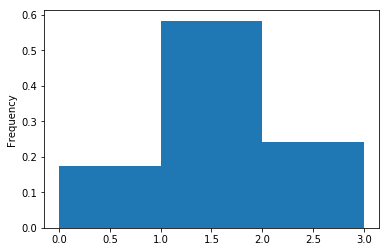

In [9]:
plt.figure()
group = data["group"]
group.plot.hist(bins=OUTPUT_SIZE, range=[0, OUTPUT_SIZE], weights=(np.ones_like(group) / float(len(group))))
plt.show()

## Protocol Distribution

In [19]:
dist = {
    "group": [],
    "protocol": [],
    "count": [],
}
for i, group in enumerate(groups):
    g = group[["protocol"]]
    i = {
        0: "0 - Latency-Bound",
        1: "1 - Bandwidth-Bound",
        2: "2 - Irregular"
    }[i]
    dist["group"].append(i)
    dist["protocol"].append("TCP")
    dist["count"].append(g[g.protocol == 0].shape[0] / float(data.shape[0]))
    dist["group"].append(i)
    dist["protocol"].append("UDP")
    dist["count"].append(g[g.protocol == 1].shape[0] / float(data.shape[0]))
plot = Bar(dist, values="count", label="group", stack="protocol")
plot.xaxis.axis_label = "Class"
plot.yaxis.axis_label = "Sample Ratio"
plot.axis.axis_label_text_font_size = "20pt"
plot.axis.major_label_text_font_size = "16pt"
plot.legend.label_text_font_size = "20pt"
plot.legend.location = "top_right"
show(plot)

## Sum Bytes / Second

    foreach row: (byte_0 + ... + byte_9) / 10

In [11]:
sum_byte = [
    groups[i][BYTE_LABELS].mean(1)
    for i in range(OUTPUT_SIZE)]

In [21]:
df = create_histogram_dataframe(
    sum_byte,
    weights=weights,
    columns=["x", "group_0", "group_1", "group_2"],
    bins="auto", hist_range=[0, 2000])
# plot = Line(df, x="x", y=["group_0", "group_1", "group_2"], plot_width=900)
plot = figure(plot_width=800)
plot.line(df["x"], df["group_0"], line_width=5, color="blue", legend="Class 0: Latency-Bound Pattern")
plot.line(df["x"], df["group_1"], line_width=5, color="green", legend="Class 1: Bandwidth-Bound Pattern")
plot.line(df["x"], df["group_2"], line_width=5, color="red", legend="Class 2: Irregular Pattern")
plot.xaxis.axis_label = "Transferred Size (Bytes/Second)"
plot.yaxis.axis_label = "Probability Density"
plot.axis.axis_label_text_font_size = "20pt"
plot.axis.major_label_text_font_size = "16pt"
plot.legend.label_text_font_size = "20pt"
plot.legend.location = "top_right"
show(plot)

## Sum Packets / Second

In [13]:
sum_packet = [
    groups[i][PACKET_LABELS].mean(1)
for i in range(OUTPUT_SIZE)]

In [22]:
df = create_histogram_dataframe(
    sum_packet,
    weights=weights,
    columns=["x", "group_0", "group_1", "group_2"],
    bins="auto", hist_range=[0, 5])
# show(Line(df, x="x", y=["group_0", "group_1", "group_2"], plot_width=900))
plot = figure(plot_width=800)
plot.line(df["x"], df["group_0"], line_width=5, color="blue", legend="Class 0: Latency-Bound Pattern")
plot.line(df["x"], df["group_1"], line_width=5, color="green", legend="Class 1: Bandwidth-Bound Pattern")
plot.line(df["x"], df["group_2"], line_width=5, color="red", legend="Class 2: Outliters Pattern")
plot.xaxis.axis_label = "Packet Rate (Packets/Second)"
plot.yaxis.axis_label = "Probability Density"
plot.axis.axis_label_text_font_size = "20pt"
plot.axis.major_label_text_font_size = "16pt"
plot.legend.label_text_font_size = "20pt"
plot.legend.location = "top_right"
show(plot)

## Std Bytes

In [15]:
std_byte = [
    groups[i][BYTE_LABELS].std(1)
    for i in range(OUTPUT_SIZE)]

In [23]:
df = create_histogram_dataframe(
    std_byte,
    weights=weights,
    columns=["x", "group_0", "group_1", "group_2"],
    bins="auto", hist_range=[0, 2000])
# show(Line(df, x="x", y=["group_0", "group_1", "group_2"], plot_width=900))
plot = figure(plot_width=800)
plot.line(df["x"], df["group_0"], line_width=5, color="blue", legend="Class 0: Latency-Bound Pattern")
plot.line(df["x"], df["group_1"], line_width=5, color="green", legend="Class 1: Bandwidth-Bound Pattern")
plot.line(df["x"], df["group_2"], line_width=5, color="red", legend="Class 2: Outliters Pattern")
plot.xaxis.axis_label = "Standard Diviation (Bytes/Second)"
plot.yaxis.axis_label = "Probability Density"
plot.axis.axis_label_text_font_size = "20pt"
plot.axis.major_label_text_font_size = "16pt"
plot.legend.label_text_font_size = "20pt"
plot.legend.location = "top_right"
show(plot)

## Std Packets

In [17]:
std_packet = [
    groups[i][PACKET_LABELS].std(1)
    for i in range(OUTPUT_SIZE)]

In [24]:
df = create_histogram_dataframe(
    std_packet,
    weights=weights,
    columns=["x", "group_0", "group_1", "group_2"],
    bins="auto", hist_range=[0, 10])
# show(Line(df, x="x", y=["group_0", "group_1", "group_2"], plot_width=900))
plot = figure(plot_width=800)
plot.line(df["x"], df["group_0"], line_width=5, color="blue", legend="Class 0: Latency-Bound Pattern")
plot.line(df["x"], df["group_1"], line_width=5, color="green", legend="Class 1: Bandwidth-Bound Pattern")
plot.line(df["x"], df["group_2"], line_width=5, color="red", legend="Class 2: Outliters Pattern")
plot.xaxis.axis_label = "Standard Diviation (Packets/Second)"
plot.yaxis.axis_label = "Probability Density"
plot.axis.axis_label_text_font_size = "20pt"
plot.axis.major_label_text_font_size = "16pt"
plot.legend.label_text_font_size = "20pt"
plot.legend.location = "top_right"
show(plot)

## Scratchpad